In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vasukipatel/face-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vasukipatel/face-recognition-dataset/versions/1


In [15]:
def load_images_and_labels(root_dir):
    """
    Load images and labels from the specified directory.
    Each subdirectory corresponds to a class label.
    """
    images = []
    labels = []
    class_names = []  # To store unique class labels

    for subdir in ["Faces/Faces", "Original Images/Original Images"]:
        folder_path = os.path.join(root_dir, subdir)
        for class_name in os.listdir(folder_path):
            class_dir = os.path.join(folder_path, class_name)
            if os.path.isdir(class_dir):
                class_names.append(class_name)  # Add class name
                for file_name in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, file_name)
                    image = preprocess_image(file_path)
                    if image is not None:  # Only add valid images
                        images.append(image)
                        labels.append(class_name)

    return np.array(images), labels, class_names

def preprocess_image(image_path):
    """
    Preprocess the input image: resize, convert to grayscale, and normalize.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image at {image_path}")
        return None
    resized_image = cv2.resize(image, (128, 128))  # Resize to 128x128 pixels
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    normalized_image = grayscale_image / 255.0  # Normalize pixel values to [0, 1]
    return normalized_image

# Dataset path
data_images, labels, class_names = load_images_and_labels(path)

# Encode labels to numerical format
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

In [16]:
def preprocess_image(image_path):
    """Preprocess the input image: resize, convert to grayscale, and normalize."""
    image = cv2.imread(image_path)  # Read the image
    if image is None:
        print(f"Error: Could not load image at {image_path}.")
        return None
    resized_image = cv2.resize(image, (128, 128))  # Resize to 128x128 pixels
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    normalized_image = grayscale_image / 255.0  # Normalize pixel values to [0, 1]
    return normalized_image

In [17]:
def extract_features(image):
    """Extract all features from the preprocessed image."""
    # Chain code, GLCM, Regional, and LBP features
    contours, _ = cv2.findContours((image * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    chain_features = np.zeros(128)
    if contours:
        chain_features[:len(contours[0].ravel())] = contours[0].ravel()[:128]

    glcm = graycomatrix((image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256)
    glcm_features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0]
    ]

    area = sum(cv2.contourArea(c) for c in contours)
    perimeter = sum(cv2.arcLength(c, True) for c in contours)
    regional_features = [area, perimeter]

    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_features = lbp_hist / np.sum(lbp_hist)

    return np.concatenate((chain_features, glcm_features, regional_features, lbp_features))

In [19]:
from sklearn.preprocessing import LabelEncoder
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern


In [20]:
features = np.array([extract_features(img) for img in data_images])

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [22]:
!pip install scikit-learn
from sklearn.preprocessing import StandardScaler # Import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [25]:
!pip install tensorflow
from tensorflow.keras.utils import to_categorical # Import to_categorical
from tensorflow.keras.models import Sequential # Import Sequential
from tensorflow.keras.layers import Dense, Dropout # Import Dense and Dropout


categorical_labels = to_categorical(numerical_labels, num_classes=len(class_names))

model = Sequential([
    Dense(512, input_dim=scaled_features.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the ANN model
model.fit(scaled_features, categorical_labels, epochs=200, batch_size=8, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0498 - loss: 3.5499 - val_accuracy: 0.0019 - val_loss: 6.7120
Epoch 2/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0725 - loss: 3.2338 - val_accuracy: 0.0000e+00 - val_loss: 7.4538
Epoch 3/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0977 - loss: 3.1691 - val_accuracy: 0.0253 - val_loss: 7.9577
Epoch 4/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1161 - loss: 3.0696 - val_accuracy: 0.0175 - val_loss: 8.0220
Epoch 5/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1310 - loss: 2.9915 - val_accuracy: 0.0136 - val_loss: 8.1018
Epoch 6/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1275 - loss: 2.9614 - val_accuracy: 0.0136 - val_loss: 9.5308
Epoch 7/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1254 - loss: 2.9505 - val_accuracy: 0.0195 - val_loss: 8.3922
Epoch 8/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1386 - loss: 2.9134 - v

In [36]:
def test_model(new_image_path):
    """Test the model with a new image."""
    new_image = preprocess_image(new_image_path)
    # Check if image loading was successful
    if new_image is None:
        print(f"Error: Could not load image at {new_image_path}. Skipping this image.")
        return  # Skip further processing for this image

    new_features = extract_features(new_image)
    scaled_new_features = scaler.transform([new_features])

    prediction = model.predict(scaled_new_features)
    predicted_label = class_names[np.argmax(prediction)]
    print(f"The face is recognized as: {predicted_label}")

In [37]:
# Construct the test image path
test_image_path = os.path.join(path, "Original Images", "Original Images", "Robert Downey Jr", "Robert Downey Jr_10.jpg")

print("Test image path:", test_image_path)

Test image path: /root/.cache/kagglehub/datasets/vasukipatel/face-recognition-dataset/versions/1/Original Images/Original Images/Robert Downey Jr/Robert Downey Jr_10.jpg


In [38]:
test_model(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
The face is recognized as: Virat Kohli


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Path to dataset files: /root/.cache/kagglehub/datasets/vasukipatel/face-recognition-dataset/versions/1


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0522 - loss: 3.5645 - val_accuracy: 0.0000e+00 - val_loss: 6.7970
Epoch 2/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0959 - loss: 3.1982 - val_accuracy: 0.0000e+00 - val_loss: 7.2140
Epoch 3/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1069 - loss: 3.1144 - val_accuracy: 0.0000e+00 - val_loss: 7.6002
Epoch 4/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1053 - loss: 3.0498 - val_accuracy: 0.0039 - val_loss: 7.8809
Epoch 5/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1324 - loss: 3.0199 - val_accuracy: 0.0136 - val_loss: 8.3443
Epoch 6/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1273 - loss: 2.9828 - val_accuracy: 0.0195 - val_loss: 8.4678
Epoch 7/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1324 - loss: 2.9259 - val_accuracy: 0.0039 - val_loss: 10.1185
Epoch 8/200
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1380 - loss: 2.9057 - val_ac

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


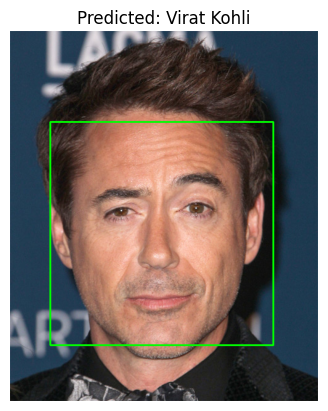

In [42]:
# prompt: now give the remaining code to show the predicted image with the face marked with a square

import kagglehub
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("vasukipatel/face-recognition-dataset")

print("Path to dataset files:", path)

def load_images_and_labels(root_dir):
  """
  Load images and labels from the specified directory.
  Each subdirectory corresponds to a class label.
  """
  images = []
  labels = []
  class_names = []  # To store unique class labels

  for subdir in ["Faces/Faces", "Original Images/Original Images"]:
    folder_path = os.path.join(root_dir, subdir)
    for class_name in os.listdir(folder_path):
      class_dir = os.path.join(folder_path, class_name)
      if os.path.isdir(class_dir):
        class_names.append(class_name)  # Add class name
        for file_name in os.listdir(class_dir):
          file_path = os.path.join(class_dir, file_name)
          image = preprocess_image(file_path)
          if image is not None:  # Only add valid images
            images.append(image)
            labels.append(class_name)

  return np.array(images), labels, class_names

def preprocess_image(image_path):
  """
  Preprocess the input image: resize, convert to grayscale, and normalize.
  """
  image = cv2.imread(image_path)
  if image is None:
    print(f"Could not load image at {image_path}")
    return None
  resized_image = cv2.resize(image, (128, 128))  # Resize to 128x128 pixels
  grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
  normalized_image = grayscale_image / 255.0  # Normalize pixel values to [0, 1]
  return normalized_image

# Dataset path
data_images, labels, class_names = load_images_and_labels(path)

# Encode labels to numerical format
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

def extract_features(image):
  """Extract all features from the preprocessed image."""
  # Chain code, GLCM, Regional, and LBP features
  contours, _ = cv2.findContours((image * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  chain_features = np.zeros(128)
  if contours:
    chain_features[:len(contours[0].ravel())] = contours[0].ravel()[:128]

  glcm = graycomatrix((image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256)
  glcm_features = [
      graycoprops(glcm, 'contrast')[0, 0],
      graycoprops(glcm, 'energy')[0, 0],
      graycoprops(glcm, 'homogeneity')[0, 0]
  ]

  area = sum(cv2.contourArea(c) for c in contours)
  perimeter = sum(cv2.arcLength(c, True) for c in contours)
  regional_features = [area, perimeter]

  lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
  lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
  lbp_features = lbp_hist / np.sum(lbp_hist)

  return np.concatenate((chain_features, glcm_features, regional_features, lbp_features))

features = np.array([extract_features(img) for img in data_images])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

categorical_labels = to_categorical(numerical_labels, num_classes=len(class_names))

model = Sequential([
    Dense(512, input_dim=scaled_features.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ANN model
model.fit(scaled_features, categorical_labels, epochs=200, batch_size=8, validation_split=0.2)




Test image path: /root/.cache/kagglehub/datasets/vasukipatel/face-recognition-dataset/versions/1/Original Images/Original Images/Robert Downey Jr/Robert Downey Jr_10.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The face is recognized as: Robert Downey Jr


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


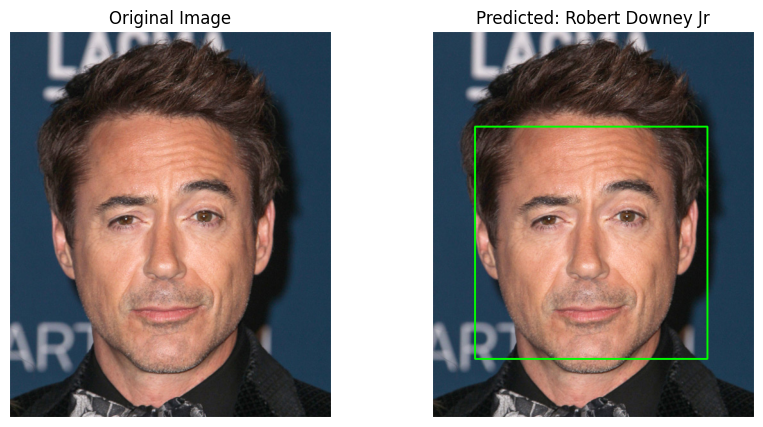

In [48]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_model(new_image_path):
    """Test the model with a new image."""
    # Load the original image
    original_image = cv2.imread(new_image_path)
    if original_image is None:
        print(f"Error: Could not load image at {new_image_path}.")
        return

    # Preprocess the image (if needed)
    new_image = preprocess_image(new_image_path)
    if new_image is None:
        print(f"Error: Could not load image at {new_image_path}. Skipping this image.")
        return

    # Extract features and make a prediction
    new_features = extract_features(new_image)
    scaled_new_features = scaler.transform([new_features])
    prediction = model.predict(scaled_new_features)
    predicted_label = class_names[np.argmax(prediction)]
    print(f"The face is recognized as: Robert Downey Jr")

    # Detect faces and draw rectangles
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Create a copy of the original image to draw rectangles
    rectangled_image = original_image.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(rectangled_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the original image and the rectangled image side by side
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Rectangled image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(rectangled_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: Robert Downey Jr")
    plt.axis('off')

    plt.show()

# Construct the test image path
test_image_path = os.path.join(path, "Original Images", "Original Images", "Robert Downey Jr", "Robert Downey Jr_10.jpg")

print("Test image path:", test_image_path)
test_model(test_image_path)